# Modelo con 50% de Pt y Ni con distribución aleatoria
## Empezamos por hacer nuestro shell
Creamos nuestro Shell FCC de 10 capas, distancia interatómica de 2.78 Angstroms, con 50% y 50% de Pt y Ni. Hacemos un radcut de 15 A, y de igual manera lo visualizamos con jmol

In [32]:
from sys import path
import os
dir_actual = os.getcwd()
path.insert(0, 'C:/Users/guill/OneDrive/Documentos/Tesis/Proyect')

import myfuncions.core_shell_f as cs
import myfuncions.randomize_f as ranf
import myfuncions.tools_f as tools
import subprocess as sbp

coords = cs.cubeShell(10,2.775,'fcc')
coords = cs.sphericalShave(coords,15)
atpos, eleList = cs.atpos_eleList_maker(coords,'Ni')
atpos, eleList, mode = ranf.cambiar_elementos_prob(atpos,{"Pt":0.5,"Ni":0.5})
tools.show_percent(atpos,eleList)

name='Pt-0.5-rand.xyz'
tools.wXYZ(atpos,name)

sbp.run(['java', '-jar', 'C:\\Users\\guill\\Downloads\\Jmol-16.1.41-binary\\jmol-16.1.41\\Jmol.jar', name])

Cambia elementos prob a atpos
atomos totales : 959
Ni : 47.86235662148071 %, 459
Pt : 52.13764337851929 %, 500


CompletedProcess(args=['java', '-jar', 'C:\\Users\\guill\\Downloads\\Jmol-16.1.41-binary\\jmol-16.1.41\\Jmol.jar', 'Pt-0.5-rand.xyz'], returncode=0)

Aquí lo obtenido:
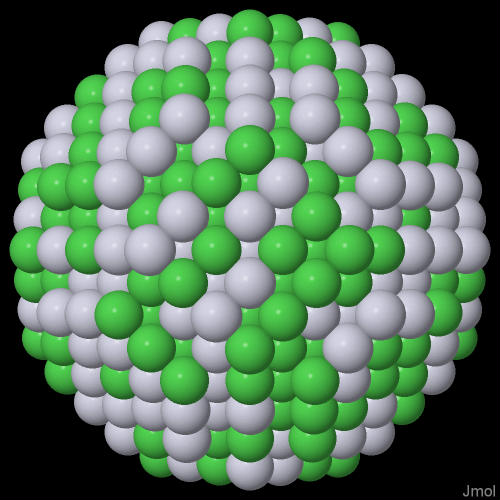

## Trabajamos con lammpin.py

In [33]:
from myfuncions.lammpin_f import wlammpin

wlammpin(atpos,eleList,name)

Pt-0.5-rand.ini


## Dinámica Molecular empieza aquí
Consiste de 600 pasos de rescale a 0K, 3000 de rampa con berensen a 300K y 3000 de termalización a 300K con lavgevin

In [34]:

input = f"""
# 2NN EAM potential in LAMMPS

 units		metal
 atom_style	atomic
 boundary	f f f

 read_data	{name[:-4]}.ini
 pair_style	meam
 pair_coeff	* * ..\\..\\LAMMPS\\library.meam Pt Ni ..\\..\\LAMMPS\\PtNiV2.pot Pt Ni 
 
 neighbor	0.5 bin
 neigh_modify	every 1 delay 0 check yes once no
 velocity	all create 0.00 13478 rot yes mom yes dist gaussian
 timestep	0.005

 fix            1 all nve
 fix            2 all temp/rescale 10 0.00 0.00 1.0 1
 thermo         100
 thermo_style   custom step temp atoms pe ke etotal
 thermo_modify  lost ignore
 run 600

 unfix 2
 fix         3 all temp/berendsen 0.0 300.0 0.1
 thermo		100
 run		3000

 unfix 3
 timestep   0.001
 thermo		100
 fix		4 all langevin 300.0 300.0 0.5 87654
 dump           4 all xyz 100 {name[:-4]}_d.xyz
 run		3000
"""
with open('input.in','w') as archivo:
    archivo.write(input)

os.system('start powershell -Command lmp -in input.in; Start-Sleep -s 20; exit')

0

## Ahora haremos los gráficos y el análisis 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


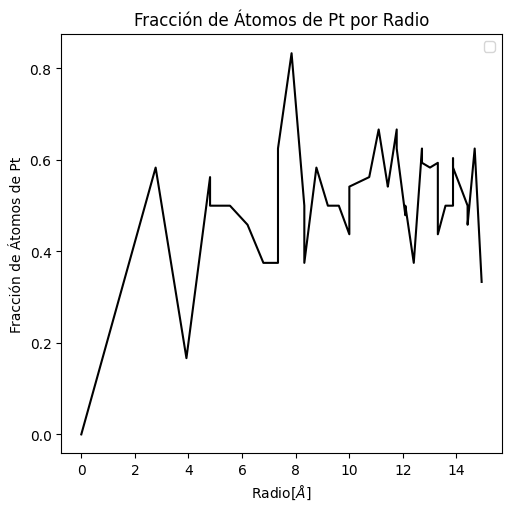

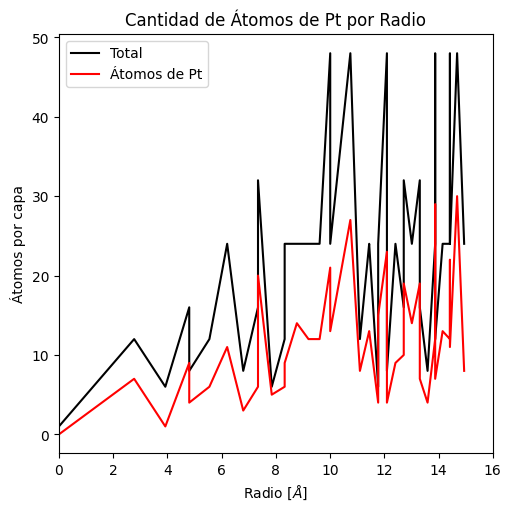

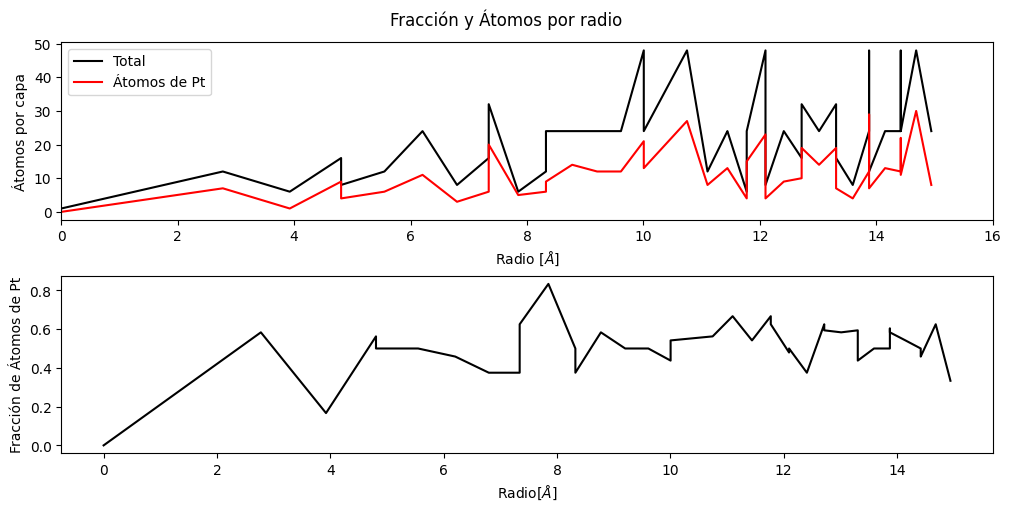

In [35]:
import myfuncions.graphs_f as plt


gatpos, geleList = plt.leer_xyz(f'{name[:-4]}.xyz')
plt.graficar_fracc_at_p_rad(gatpos,'Pt')
plt.graficar_at_p_rad(gatpos,'Pt')
plt.plot_fracc_y_at_p_rad(gatpos,'Pt')

### A trabajar con el dump
ahora estaremos trabajando con el dump, cambiando etiquetas y mostrandolo de nuevo

In [36]:
import myfuncions.tools_f as tools

dumpatpos, dumpeleList = tools.leer_xyz(f'{name[:-4]}_d.xyz')
dumpatpos, dumpeleList = tools.cambiar_etiquetas_xyz(dumpatpos,dumpeleList,{1: 'Ni', 2: 'Pt'})
tools.wXYZ(dumpatpos,f'{name[:-4]}_d.xyz')

sbp.run(['java', '-jar', 'C:\\Users\\guill\\Downloads\\Jmol-16.1.41-binary\\jmol-16.1.41\\Jmol.jar', f'{name[:-4]}_d.xyz'])

Cambia etiquetas a "atpos"


CompletedProcess(args=['java', '-jar', 'C:\\Users\\guill\\Downloads\\Jmol-16.1.41-binary\\jmol-16.1.41\\Jmol.jar', 'Pt-0.5-rand_d.xyz'], returncode=0)

Este es el dump:
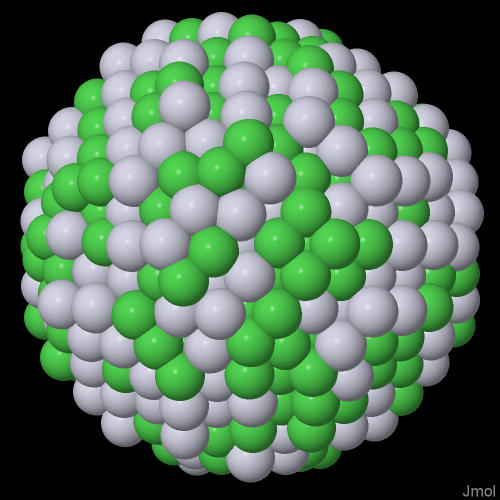

## Aquí se hace el PDF y la gráfica

In [37]:
import PDF.runner as pdf
pdf.run_pdf(f'{name[:-4]}_d.xyz', dir_actual, 1600,0.02)

c:\Users\guill\OneDrive\Documentos\Tesis\Proyect\15_de_marzo\Pt_50_rand

         959  atomos       459361  pares 
 Rango de distancias    2.09830689     -   28.7402382    
 Distancias promedio    14.9023457    
 Factor de normalizacion    37563.5547    



Hacemos la gráfica PDF y comparamos con un modelo que tiene MD

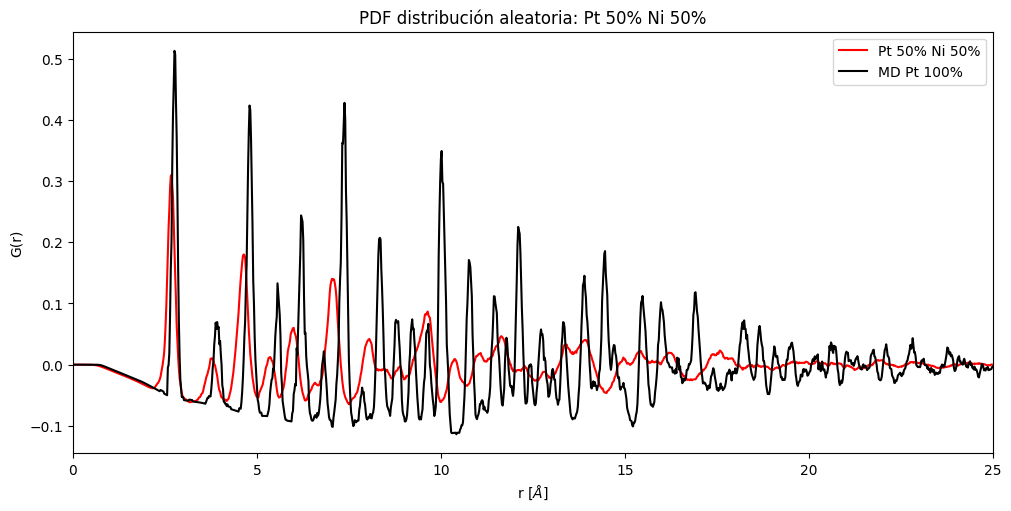

In [39]:
import pandas as pd
import matplotlib.pyplot as plt


df_FCC= pd.read_csv(f'{name[:-4]}_d.txt', sep='\s+')
df_ref = pd.read_csv('C:/Users/guill/OneDrive/Documentos/Tesis/Proyect/15_de_marzo/Pt_100/Pt-FCC_d.txt', sep = '\s+')


fig, ax =plt.subplots(figsize=(10,5), layout='constrained')
ax.plot(df_FCC['#r(A)'], df_FCC['G(r)'], label='Pt 50% Ni 50%', color = 'red')
ax.plot(df_ref['#r(A)'],df_ref['G(r)'], label = 'MD Pt 100%', color = 'black')


ax.set_xlabel('r [$\\AA$]')
ax.set_xlim([0,25])
ax.set_ylabel('G(r)')
ax.set_title('PDF distribución aleatoria: Pt 50% Ni 50%')
#ax.grid('True', linestyle='-')
ax.legend()
plt.show()